In [28]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import mplfinance as mpf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks

In [91]:
stock_name = "AAPL"

In [165]:
def prepare_data(stock_name, period="5y", interval="1d"):

    recent_data = yf.download(stock_name, period=period, interval=interval)
    data_200 = yf.download(stock_name, period="5y", interval="1d").tail(len(recent_data) + 200)
    data_200 = data_200.drop(columns=["Adj Close"])

    data_200["last_close"] = data_200["Close"].shift(1)
    data_200.fillna(method="bfill", inplace=True)

    data_200["movement"] = data_200["Close"] - data_200["Open"]

    data_200["200_day"] = data_200["Close"].rolling(window=200).mean()

    recent_data = data_200.tail(len(recent_data))

    recent_data = recent_data.iloc[:-1]

    # add_plot = mpf.make_addplot(recent_data["200_day"], color="blue", linestyle="--")

    return recent_data

prepare_data(stock_name, "1y")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\yahli\AppData\Local\Temp\ipykernel_18260\2875853402.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_200.fillna(method="bfill", inplace=True)


,Open,High,Low,Close,Volume,last_close,movement,200_day
Date,,,,,,,,
2023-08-08,179.690002,180.270004,177.580002,179.800003,67823000,178.850006,0.110001,160.36860
2023-08-09,180.869995,180.929993,177.009995,178.190002,60378500,179.800003,-2.679993,160.54260
2023-08-10,179.479996,180.750000,177.600006,177.970001,54686900,178.190002,-1.509995,160.69610
2023-08-11,177.320007,178.619995,176.550003,177.789993,51988100,177.970001,0.469986,160.83780
2023-08-14,177.970001,179.690002,177.309998,179.460007,43675600,177.789993,1.490005,160.97340
...,...,...,...,...,...,...,...,...
2024-07-31,221.440002,223.820007,220.630005,222.080002,50036300,218.800003,0.639999,189.11830
2024-08-01,224.369995,224.479996,217.020004,218.360001,62501000,222.080002,-6.009995,189.31585
2024-08-02,219.149994,225.600006,217.710007,219.860001,105568600,218.360001,0.710007,189.52155


In [166]:
recent_data = prepare_data(stock_name, "1y")
recent_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\yahli\AppData\Local\Temp\ipykernel_18260\2875853402.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_200.fillna(method="bfill", inplace=True)


,Open,High,Low,Close,Volume,last_close,movement,200_day
Date,,,,,,,,
2023-08-08,179.690002,180.270004,177.580002,179.800003,67823000,178.850006,0.110001,160.36860
2023-08-09,180.869995,180.929993,177.009995,178.190002,60378500,179.800003,-2.679993,160.54260
2023-08-10,179.479996,180.750000,177.600006,177.970001,54686900,178.190002,-1.509995,160.69610
2023-08-11,177.320007,178.619995,176.550003,177.789993,51988100,177.970001,0.469986,160.83780
2023-08-14,177.970001,179.690002,177.309998,179.460007,43675600,177.789993,1.490005,160.97340
...,...,...,...,...,...,...,...,...
2024-07-31,221.440002,223.820007,220.630005,222.080002,50036300,218.800003,0.639999,189.11830
2024-08-01,224.369995,224.479996,217.020004,218.360001,62501000,222.080002,-6.009995,189.31585
2024-08-02,219.149994,225.600006,217.710007,219.860001,105568600,218.360001,0.710007,189.52155


In [168]:

X = recent_data.drop(columns=["Close", "movement","Volume"])
print(X)
y = recent_data["movement"]
train_X,val_X,train_y,val_y = train_test_split(X,y,random_state = 1)
input_shape = [5]


early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=40, # how many epochs to wait before stopping
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(128, activation='relu',input_shape = input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])


optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(

    optimizer=optimizer,
    loss="mse",
)
EPOCHS = 10000
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=64,
    epochs=EPOCHS,
    # callbacks=[early_stopping],
    verbose=0,
    
)



                  Open        High         Low  last_close    200_day
Date                                                                 
2023-08-08  179.690002  180.270004  177.580002  178.850006  160.36860
2023-08-09  180.869995  180.929993  177.009995  179.800003  160.54260
2023-08-10  179.479996  180.750000  177.600006  178.190002  160.69610
2023-08-11  177.320007  178.619995  176.550003  177.970001  160.83780
2023-08-14  177.970001  179.690002  177.309998  177.789993  160.97340
...                ...         ...         ...         ...        ...
2024-07-31  221.440002  223.820007  220.630005  218.800003  189.11830
2024-08-01  224.369995  224.479996  217.020004  222.080002  189.31585
2024-08-02  219.149994  225.600006  217.710007  218.360001  189.52155
2024-08-05  199.089996  213.500000  196.000000  219.860001  189.68215
2024-08-06  205.300003  209.990005  201.070007  209.270004  189.83910

[251 rows x 5 columns]


c:\Users\yahli\anaconda3\envs\Stocks\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [161]:
check_data = prepare_data(stock_name, "5d", "1d")

# print(check_data)
check_X = check_data.drop(columns=["Close","Volume", "movement"])
# print(checl_data.head())
print(check_X.tail(1))

print(model.predict(check_X.tail(1)))
print(check_X.tail(1).Open[0] + model.predict(check_X.tail(1))[0])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low    200_day
Date                                                     
2024-08-06  205.300003  209.990005  201.070007  189.68215



C:\Users\yahli\AppData\Local\Temp\ipykernel_18260\3183890784.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_200.fillna(method="bfill", inplace=True)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_108" is incompatible with the layer: expected axis -1 of input shape to have value 5, but received input with shape (1, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 4), dtype=float32)
  • training=False
  • mask=None

Minimum validation loss: 4.873538017272949


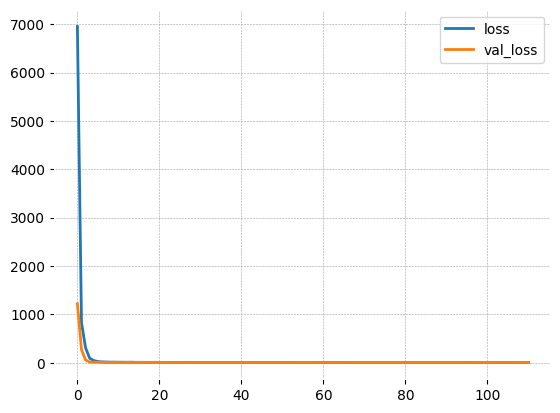

In [121]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))